In [1]:
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [2]:
BATCH_SIZE = 8

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [3]:
train_data_dir = 'DS/train'
test_data_dir = 'DS/test'

class_subset = ['Minimalist', 'Modern', 'Traditional']

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 693 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 189 images belonging to 3 classes.


In [4]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [6]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

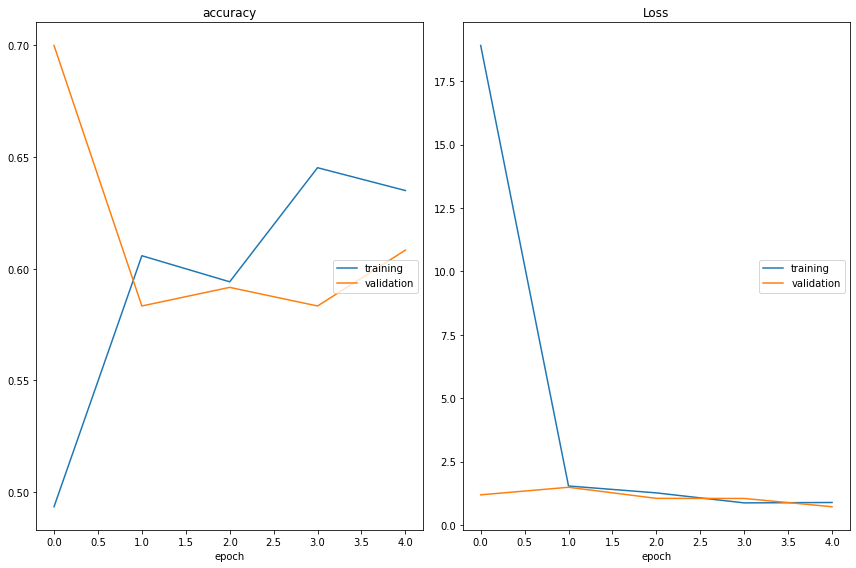

accuracy
	training         	 (min:    0.493, max:    0.645, cur:    0.635)
	validation       	 (min:    0.583, max:    0.700, cur:    0.608)
Loss
	training         	 (min:    0.873, max:   18.909, cur:    0.888)
	validation       	 (min:    0.721, max:    1.488, cur:    0.721)
Wall time: 2min 35s


In [7]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [8]:
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') 

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [9]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 71.96%


In [10]:
traingen.reset()
validgen.reset()
testgen.reset()

optim_2 = Adam(lr=0.0001)

vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_1/dense_3/MatMul_1 (defined at <timed exec>:11) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5237]

Function call stack:
train_function


In [13]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [13]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 80.95%


In [14]:
# import tf2onnx
# tf2onnx.convert.from_keras(vgg_model, output_path='model.onnx')